In [1]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
from flax import nnx  # The Flax NNX API.
from functools import partial
import jax.numpy as jnp  # JAX NumPy
import jax
import optax
from linearRNN import forward_h
from linearRNN import forward
from linearRNN import init_lru_parameters
from linearRNN import binary_operator_diag
import numpy as np
from flax import linen as nn


In [ ]:
rnn=1 #rnn=0:transformation of the inputs with fixed RNN weights, rnn=1: adding the RNN module on the model to learn the weight matrices
hidden_neuron=256
hidden_size=2048
learning_rate = 0.005
momentum = 0.9
train_steps=2500
eval_every = 100
batch_size=32
r_min = 0.99
r_max = 0.999
max_phase = 0.314
method_name="LRUMLP"
dataset_name="MNIST"
leave_data=1

In [3]:
#Import data
cifar=tf.keras.datasets.mnist.load_data()
train=cifar[0]
test=cifar[1]

train_x_len=train[0].shape[0]
train_x_size=int(jnp.prod(jnp.array(train[0].shape[1:])))
test_x_len=test[0].shape[0]
test_x_size=int(jnp.prod(jnp.array(test[0].shape[1:])))

train_x=train[0].reshape((train_x_len,train_x_size))/255
train_y=train[1].reshape(train_x_len)


test_x=test[0].reshape((test_x_len,test_x_size))/255
test_y=test[1].reshape(test_x_len)

#test_x=jnp.append(train_x[30000:],test_x,axis=0)
#test_y=jnp.append(train_y[30000:],test_y)
#
#train_x=train_x[:30000]
#train_y=train_y[:30000]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [4]:
if rnn:
    train_hidden_state=train_x
    test_hidden_state=test_x
else:
    param=init_lru_parameters(hidden_size,train_x_size,r_min=0.999,r_max=0.9999,max_phase=6.28)
    param2=init_lru_parameters(hidden_size,train_x_size,r_min=0.999,r_max=0.9999,max_phase=6.28)
    train_hidden_state=jnp.real(forward_h(param,train_x))
    test_hidden_state=jnp.real(forward_h(param2,test_x))

In [5]:
train_ds=tf.data.Dataset.from_tensor_slices((jnp.real(train_hidden_state),jnp.array(train_y,dtype=int)))
test_ds=tf.data.Dataset.from_tensor_slices((jnp.real(test_hidden_state),jnp.array(test_y,dtype=int)))

train_ds = train_ds.repeat().shuffle(100)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [6]:
print(train_hidden_state.shape)
print(test_hidden_state.shape)

(60000, 784)
(10000, 784)


In [7]:
parallel_scan = jax.lax.associative_scan
Array = jax.Array
class LRU(nnx.Module):
    def __init__(
        self,
        in_features: int,
        hidden_features: int,  # not inferred from carry for now
        *,
        r_min=r_min,
        r_max=r_max,
        max_phase=max_phase,
    ):
        self.in_features = in_features
        self.hidden_features = hidden_features
        # self.kernel_init = kernel_init
        # self.recurrent_kernel_init = recurrent_kernel_init
        # self.bias_init = bias_init
        nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = init_lru_parameters(
            hidden_features, in_features, r_min=r_min, r_max=r_max, max_phase=max_phase
        )

        self.nu_log = nnx.Param(nu_log)
        self.theta_log = nnx.Param(theta_log)
        self.B_re = nnx.Param(B_re)
        self.B_im = nnx.Param(B_im)
        self.C_re = nnx.Param(C_re)
        self.C_im = nnx.Param(C_im)
        self.D = nnx.Param(D)
        self.gamma_log = nnx.Param(gamma_log)

    def __call__(self, inputs: Array) -> tuple[Array, Array]:  # type: ignore[override]
        # jax.debug.print("test:{}", jnp.sin(self.nu_log + self.theta_log))
        Lambda = jnp.exp(
            -jnp.exp(self.nu_log.value) + 1j * jnp.exp(self.theta_log.value)
        )
        B_norm = (self.B_re.value + 1j * self.B_im.value) * jnp.expand_dims(
            jnp.exp(self.gamma_log.value), axis=-1
        )
        # Running the LRU + output projection
        # For details on parallel scan, check discussion in Smith et al (2022).
        Lambda_elements = jnp.repeat(Lambda[None, ...], inputs.shape[0], axis=0)
        Bu_elements = jax.vmap(lambda u: B_norm @ u)(inputs)
        elements = (Lambda_elements, Bu_elements)
        _, h = parallel_scan(binary_operator_diag, elements)
        
        return jnp.real(h)

In [8]:
from flax import nnx
import optax
from flax.nnx.nn.recurrent import LSTMCell,GRUCell
from func import LRNNCell,LRUCell,LRUfixCell

class MLP(nnx.Module):
  #DON'T FORGET TO CHANGE THE MODEL NAME BEFORE RUNNING
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.rnn=LRU(in_features=train_x_size, hidden_features=din, r_min=r_min,r_max=r_max,max_phase=max_phase)
    self.linear = nnx.Linear(din, dmid, rngs=rngs)
    self.linear_out = nnx.Linear(dmid, dout, rngs=rngs)

  def __call__(self, x):
    if rnn:
      x=self.rnn(x)
    x=self.linear(x)
    x = nnx.softplus(x)
    return self.linear_out(x)

model = MLP(hidden_size, hidden_neuron, 10, rngs=nnx.Rngs(0))  # eager initialization

nnx.display(model)

MLP(
  rnn=LRU(
    in_features=784,
    hidden_features=2048,
    nu_log=Param(
      value=Array(shape=(2048,), dtype=float64)
    ),
    theta_log=Param(
      value=Array(shape=(2048,), dtype=float64)
    ),
    B_re=Param(
      value=Array(shape=(2048, 784), dtype=float64)
    ),
    B_im=Param(
      value=Array(shape=(2048, 784), dtype=float64)
    ),
    C_re=Param(
      value=Array(shape=(784, 2048), dtype=float64)
    ),
    C_im=Param(
      value=Array(shape=(784, 2048), dtype=float64)
    ),
    D=Param(
      value=Array(shape=(784,), dtype=float64)
    ),
    gamma_log=Param(
      value=Array(shape=(2048,), dtype=float64)
    )
  ),
  linear=Linear(
    kernel=Param(
      value=Array(shape=(2048, 256), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(256,), dtype=float32)
    ),
    in_features=2048,
    out_features=256,
    use_bias=True,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function varianc

In [9]:
import optax

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=MLP(
    rnn=LRU(
      in_features=784,
      hidden_features=2048,
      nu_log=Param(
        value=Array(shape=(2048,), dtype=float64)
      ),
      theta_log=Param(
        value=Array(shape=(2048,), dtype=float64)
      ),
      B_re=Param(
        value=Array(shape=(2048, 784), dtype=float64)
      ),
      B_im=Param(
        value=Array(shape=(2048, 784), dtype=float64)
      ),
      C_re=Param(
        value=Array(shape=(784, 2048), dtype=float64)
      ),
      C_im=Param(
        value=Array(shape=(784, 2048), dtype=float64)
      ),
      D=Param(
        value=Array(shape=(784,), dtype=float64)
      ),
      gamma_log=Param(
        value=Array(shape=(2048,), dtype=float64)
      )
    ),
    linear=Linear(
      kernel=Param(
        value=Array(shape=(2048, 256), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(256,), dtype=float32)
      ),
      in_features=2048,
      out

In [10]:
import jax
def loss_fn(model: MLP, batch):
  logits = model(batch[0])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch[1]
  ).mean()
  #print(logits.shape)
  #print(batch[1].shape)
  return loss, logits

@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.
  optimizer.update(grads)  # In-place updates.
  predicted_labels = jnp.argmax(logits, axis=-1)
  actual_labels = batch[1]
  #jax.debug.print("Predictions: {}",predicted_labels[:5].astype(int))
  #jax.debug.print("Actual Labels: {}",actual_labels[:5].astype(int))
  
@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.

In [11]:
#Train the model + evaluation with the test data
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print(
      f"[train] step: {step}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"[test] step: {step}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

[train] step: 100, loss: 2.981975555419922, accuracy: 10.488861083984375
[test] step: 100, loss: 2.2964110374450684, accuracy: 12.840545654296875
[train] step: 200, loss: 2.295363664627075, accuracy: 12.15625
[test] step: 200, loss: 2.289327383041382, accuracy: 11.688701629638672
[train] step: 300, loss: 2.287635087966919, accuracy: 13.65625
[test] step: 300, loss: 2.5052924156188965, accuracy: 13.14102554321289
[train] step: 400, loss: 2.251019239425659, accuracy: 14.84375
[test] step: 400, loss: 2.237868070602417, accuracy: 14.733573913574219
[train] step: 500, loss: 2.247922658920288, accuracy: 14.218750953674316
[test] step: 500, loss: 2.2523303031921387, accuracy: 14.943909645080566
[train] step: 600, loss: 2.2307071685791016, accuracy: 16.28125
[test] step: 600, loss: 2.238520383834839, accuracy: 15.464743614196777
[train] step: 700, loss: 2.240325450897217, accuracy: 15.96875
[test] step: 700, loss: 2.294483184814453, accuracy: 17.457931518554688
[train] step: 800, loss: 2.23034

In [ ]:
#Save the training results into csv
import pandas as pd

if leave_data:
    data=pd.DataFrame({"step":np.arange(eval_every,train_steps+eval_every,eval_every),"train_loss":metrics_history['train_loss'],
                       "test_loss":metrics_history['test_loss'],"train_accuracy":metrics_history['train_accuracy'],
                       "test_accuracy":metrics_history['test_accuracy']})
    data.to_csv(method_name+"_nr"+str(hidden_neuron)+"_d"+str(hidden_size)+"_"+dataset_name+"_step"+str(train_steps)+".csv")

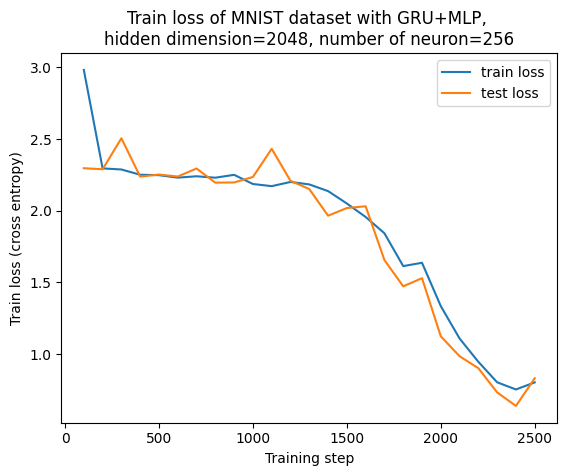

In [ ]:
#Plot the loss
import matplotlib.pyplot as plt

plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['train_loss'],label="train loss")
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['test_loss'],label="test loss")
plt.title("Train loss of MNIST dataset with GRU+MLP, \nhidden dimension="+str(hidden_size)+", number of neuron="+str(hidden_neuron))
plt.xlabel("Training step")
plt.ylabel("Train loss (cross entropy)")
plt.legend()
if leave_data:
    plt.savefig("loss_"+method_name+"_"+str(hidden_neuron)+"_"+dataset_name+"_step"+str(train_steps)+".jpg")
plt.show()

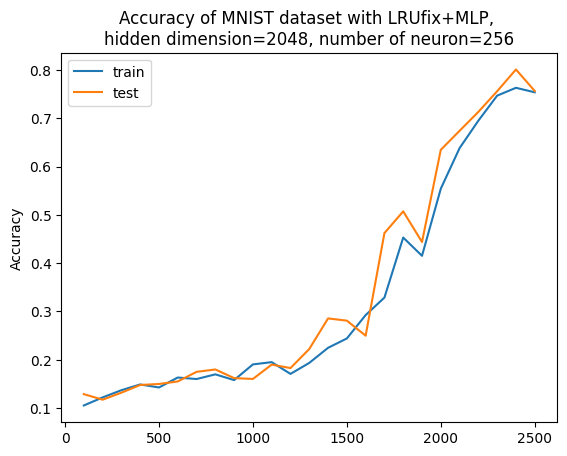

In [ ]:
#Plot the accuracy
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['train_accuracy'],label="train")
plt.plot(np.arange(eval_every,train_steps+eval_every,eval_every),metrics_history['test_accuracy'],label="test")
plt.title("Accuracy of MNIST dataset with LRUfix+MLP, \nhidden dimension="+str(hidden_size)+", number of neuron="+str(hidden_neuron))
plt.ylabel("Accuracy")
plt.legend()
if leave_data:
    plt.savefig("accuracy_"+method_name+"_"+str(hidden_neuron)+"_"+dataset_name+"_step"+str(train_steps)+".jpg")
plt.show()